In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from math import sin, cos, pi


from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
     Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data_path = '/content/drive/MyDrive/AIP_AI1503_Group7 /Source/Dataset'

In [4]:
train_file = pd.read_csv(data_path + '/training.csv', sep = ',')
test_file = pd.read_csv(data_path + '/test.csv', sep = ',')

In [5]:
train_file.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [6]:
test_file.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
train_file.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [8]:
clean_train_file = train_file.dropna(axis=0, how='any', inplace=False)
train_file = train_file.fillna(method='ffill')

In [9]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop(['Image'], axis=1)
    keypoint_features = []
    for idx, features in keypoint_data.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.array(keypoint_features, dtype=float)
    return keypoint_features

train_images = load_images(train_file)
images = load_images(clean_train_file)

train_keypoints = load_keypoints(train_file)
keypoints = load_keypoints(clean_train_file)

test_images = load_images(test_file)

In [10]:
class aug_config:
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True
    rotation_angles = [12]
    pixel_shifts = [12]

In [11]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

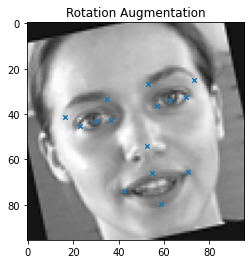

In [12]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if aug_config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(images, keypoints, aug_config.rotation_angles)
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[20], rotated_train_keypoints[20], axis, "Rotation Augmentation")

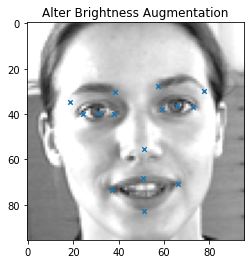

In [13]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if aug_config.brightness_augmentation:
    altered_brightness_images, altered_brightness_keypoints = alter_brightness(images, keypoints)
    train_images = np.concatenate((train_images, altered_brightness_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_images[20], altered_brightness_keypoints[20], axis, "Alter Brightness Augmentation")

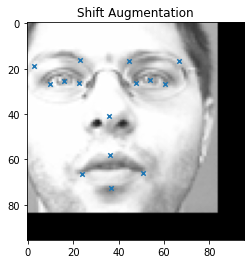

In [14]:
def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if aug_config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(images, keypoints, aug_config.pixel_shifts)
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[20], shifted_train_keypoints[20], axis, "Shift Augmentation")

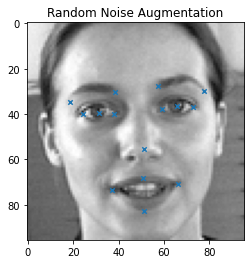

In [15]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if aug_config.random_noise_augmentation:
    noisy_train_images = add_noise(images)
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[20], keypoints[20], axis, "Random Noise Augmentation")

In [16]:
print(train_images.shape)
print(train_keypoints.shape)

(24099, 96, 96, 1)
(24099, 30)


In [17]:
def inception_like(input_layer, filter1, filter2, filter3):
  # 1x1 conv
  conv1 = Conv2D(filter1, (1,1), padding='same', activation='relu')(input_layer)
  bn1 = BatchNormalization()(conv1)
  # 3x3 conv
  conv3 = Conv2D(filter2, (3,3), padding='same', activation='relu')(input_layer)
  bn3 = BatchNormalization()(conv3)
  # 5x5 conv
  conv5 = Conv2D(filter3, (5,5), padding='same', activation='relu')(input_layer)
  bn5 = BatchNormalization()(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(input_layer)
  # concatenate filters, assumes filters/channels last
  layer_out = Concatenate(axis=-1)([bn3, bn5, pool])
  return layer_out

In [18]:
input_im = Input(shape=(96, 96, 1))
def model():

  x1 = inception_like(input_im, 64, 64, 32)
  x1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x1)

  x2 = inception_like(x1, 64, 64, 32)
  x2 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2)
  
  x2_1 = inception_like(x2, 96, 96, 64)
  x2_1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2_1)  

  x3 = inception_like(x2_1, 96, 128, 64)
  x3 = MaxPooling2D()(x3)

  x3_1 = inception_like(x3, 128, 256, 128)
  x3_1 = GlobalAveragePooling2D()(x3_1)

  x4 = Flatten()(x3_1)
  x4 = Dense(1024, kernel_regularizer=l2(l2=0.03))(x4)
  x4 = Dropout(0.2)(x4)

  pred = Dense(30)(x4)
  model = Model(inputs=input_im, outputs=pred, name='Inception_Like')

  return model

In [19]:
face_key_model_augment = model()
face_key_model_augment.summary()

Model: "Inception_Like"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         conv2d_1[0][0]                   
_____________________________________________________________________________________

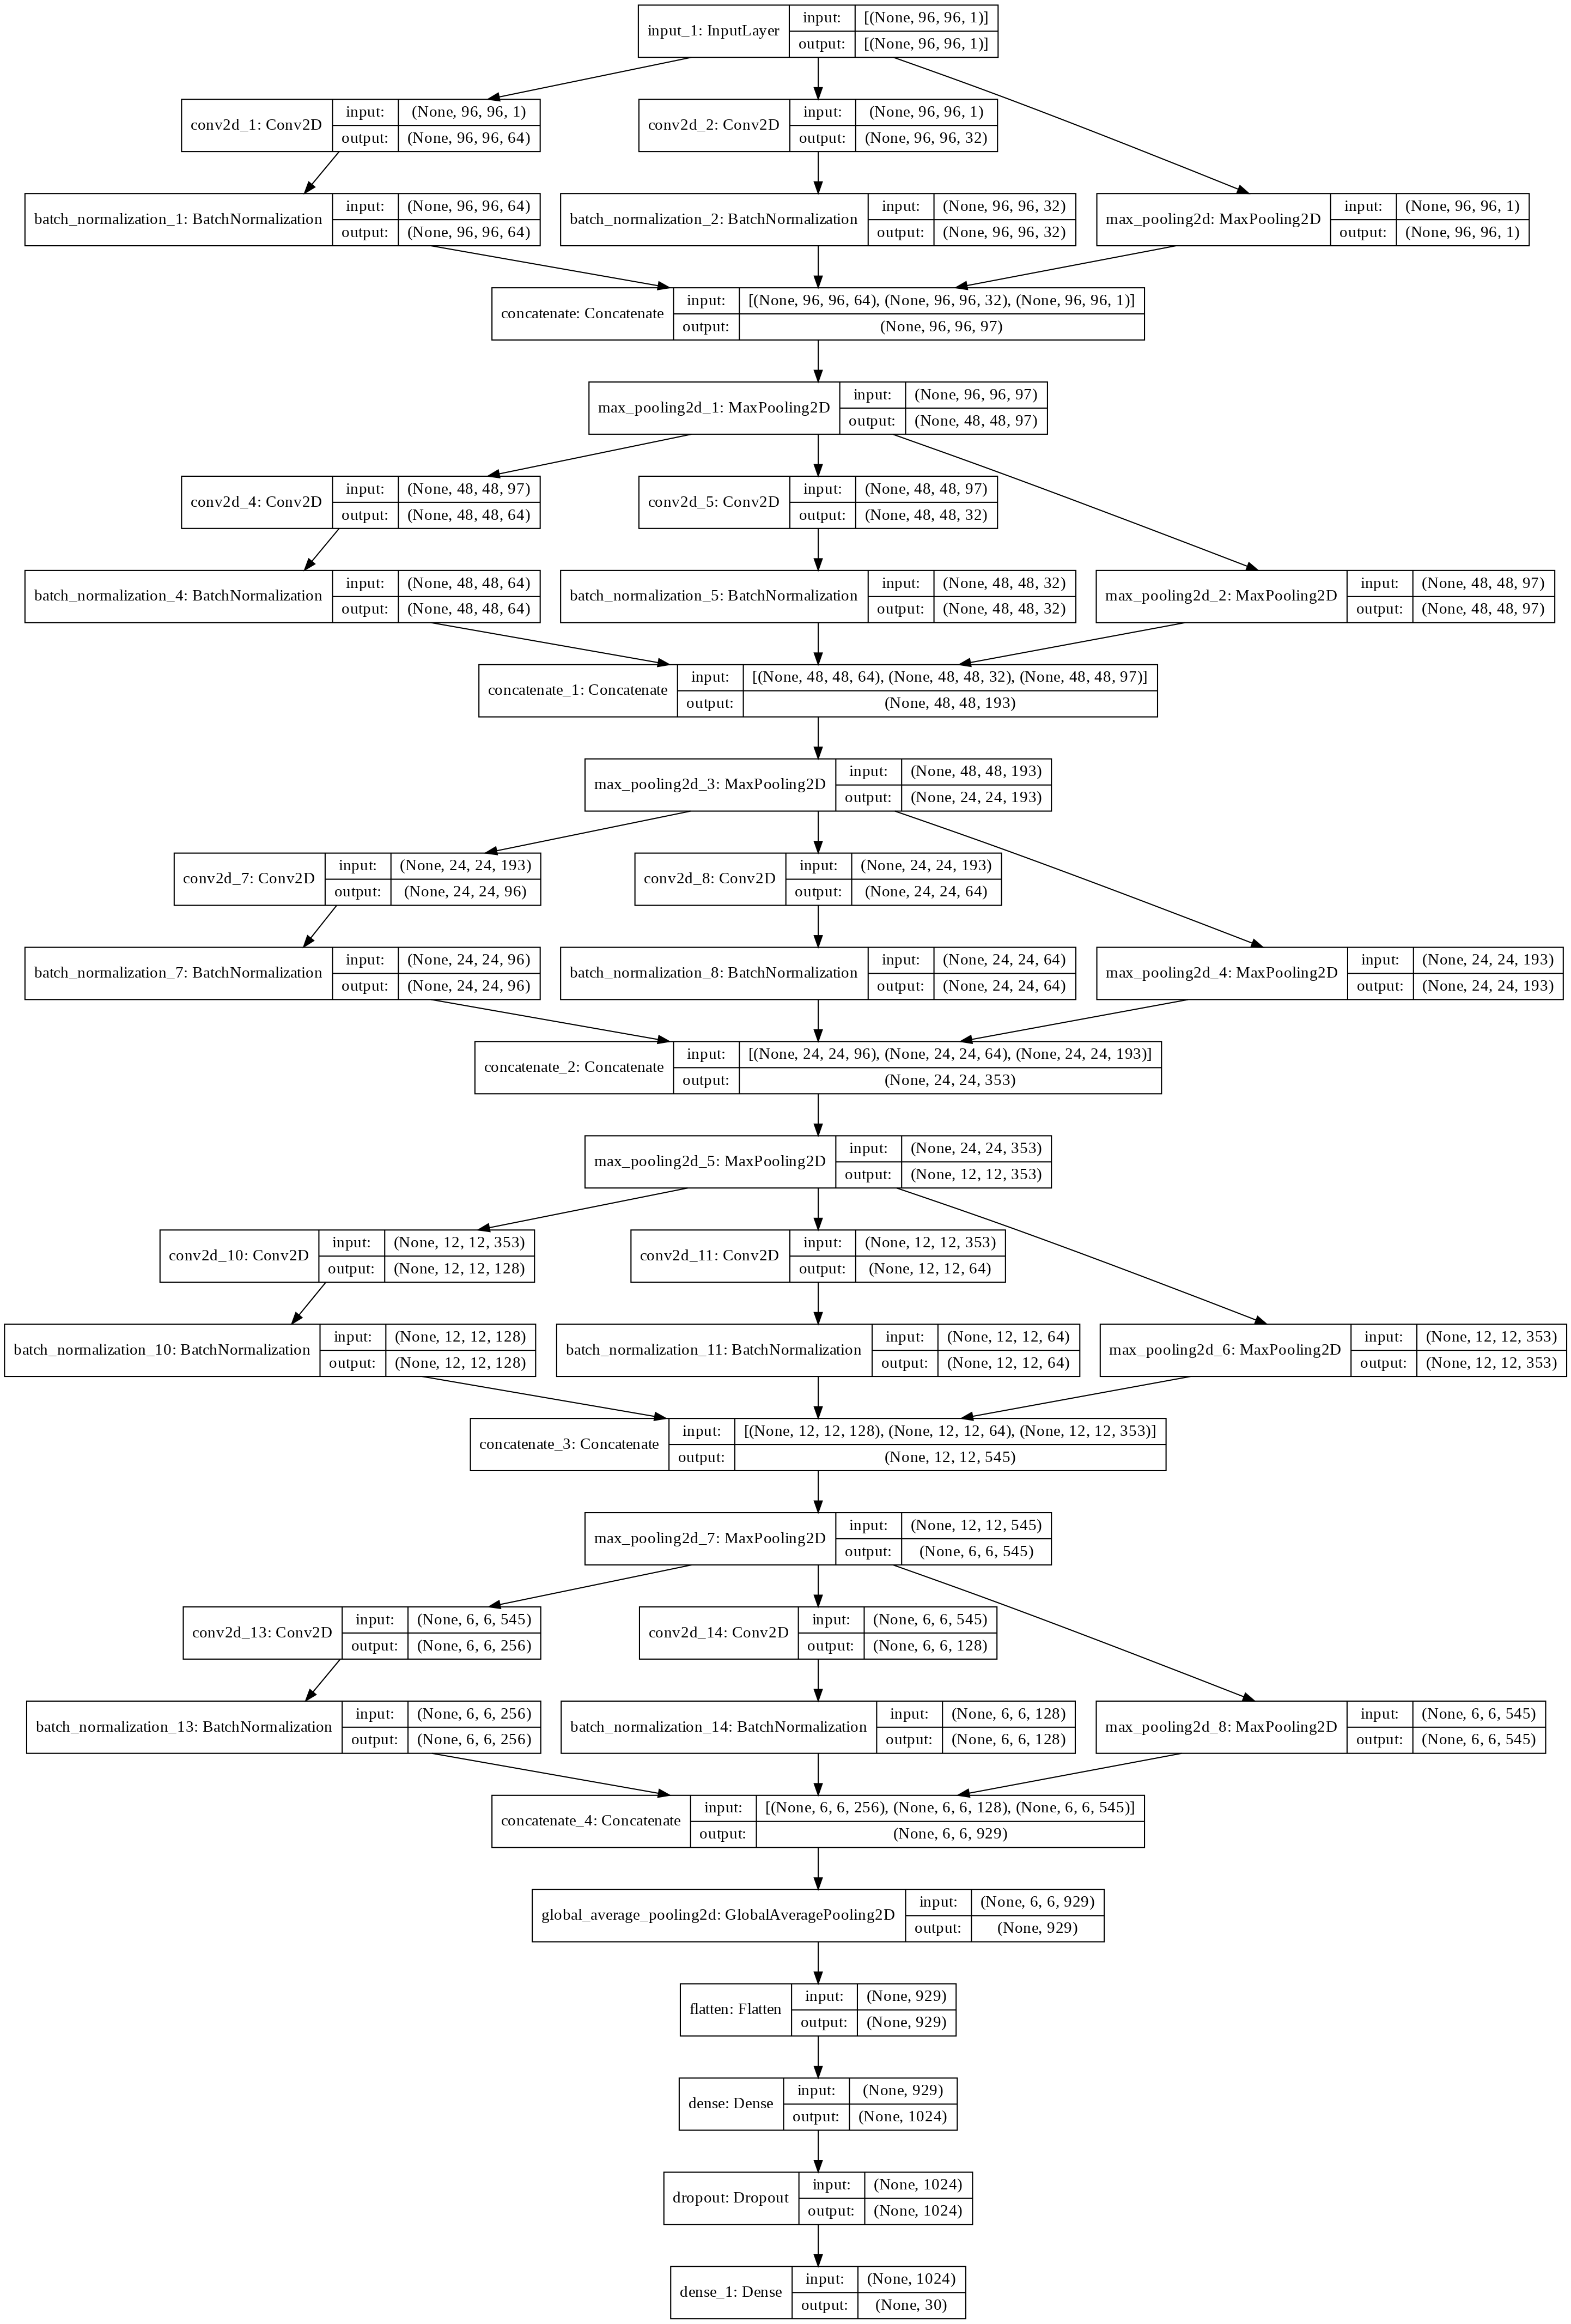

In [20]:
tf.keras.utils.plot_model(face_key_model_augment, show_shapes=True, to_file=data_path + "/inception_like_model.png", dpi=150)

In [21]:
face_key_model_augment.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3e-3), metrics=['mae'])

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

face_key_model_augment_train_clean = face_key_model_augment.fit(train_images, train_keypoints, 
                                                          validation_split= 0.15, batch_size=64, epochs=100, 
                                                          callbacks=[earlyStopping, rlp])

Epoch 1/100
321/321 [==============================] - 104s 221ms/step - loss: 72.4616 - mae: 5.2182 - val_loss: 193.9889 - val_mae: 11.3192
Epoch 2/100
321/321 [==============================] - 69s 215ms/step - loss: 32.3561 - mae: 3.8616 - val_loss: 76.5993 - val_mae: 6.6396
Epoch 3/100
321/321 [==============================] - 69s 215ms/step - loss: 22.9201 - mae: 3.3226 - val_loss: 101.1013 - val_mae: 8.3340
Epoch 4/100
321/321 [==============================] - 69s 215ms/step - loss: 19.3942 - mae: 3.0834 - val_loss: 75.2000 - val_mae: 7.1573
Epoch 5/100
321/321 [==============================] - 69s 214ms/step - loss: 18.8374 - mae: 3.0535 - val_loss: 54.8451 - val_mae: 5.4303
Epoch 6/100
321/321 [==============================] - 69s 214ms/step - loss: 16.6245 - mae: 2.8674 - val_loss: 61.8160 - val_mae: 6.1609
Epoch 7/100
321/321 [==============================] - 69s 214ms/step - loss: 16.7187 - mae: 2.8683 - val_loss: 26.6067 - val_mae: 3.6064
Epoch 8/100
321/321 [=========

<class 'list'>


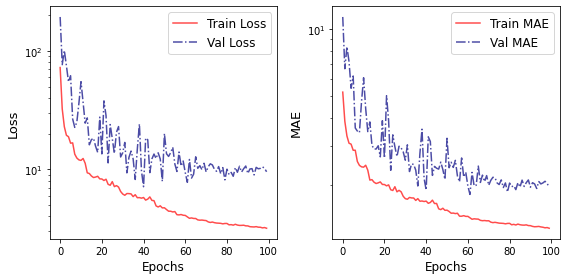

In [25]:
mae = face_key_model_augment_train_clean.history['mae']
# mae = [i for i in mae if i<60]
print (type(mae))
val_mae = face_key_model_augment_train_clean.history['val_mae']
# val_mae = [i for i in val_mae if i<60]

loss = face_key_model_augment_train_clean.history['loss']
# loss = [i for i in loss if i<1200]
val_loss = face_key_model_augment_train_clean.history['val_loss']
# val_loss = [i for i in val_loss if i<1200]

fig = plt.figure(figsize=(8, 4))

fig.add_subplot(121)
plt.plot(range(len(loss)), loss, linestyle='-', color='red', alpha=0.7, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, linestyle='-.', color='navy', alpha=0.7, label='Val Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12)

fig.add_subplot(122)
plt.plot(range(len(mae)), mae, linestyle='-', color='red', alpha=0.7, label='Train MAE')
plt.plot(range(len(val_mae)), val_mae, linestyle='-.', color='navy', alpha=0.7, label='Val MAE')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig(data_path+'train_loss_mae.png', dpi=150)
plt.show()